<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Добавление-признаков" data-toc-modified-id="Добавление-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Добавление признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Результаты-тренировочных-выборок" data-toc-modified-id="Результаты-тренировочных-выборок-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Результаты тренировочных выборок</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install -Uq scikit-learn

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [3]:
sns.set(rc={'figure.figsize':(15,4)})
def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [7]:
data.shape

(26496, 1)

<b>Датасет состоит из 26496 строк и 1 столбца после преобразований.</b>

<b>Осуществим ресемплирование по одному часу</b>

In [8]:
data = data.sort_index()
data = data.resample('1H').sum()

## Анализ

<b>Посмотрим на тренд, сезонность и остаток датасета, построим для них графики. Возьмём последний месяц, посмотрим эти характеристики на нём</b>

<div class="alert alert-info">
Это характеристики за август
</div>

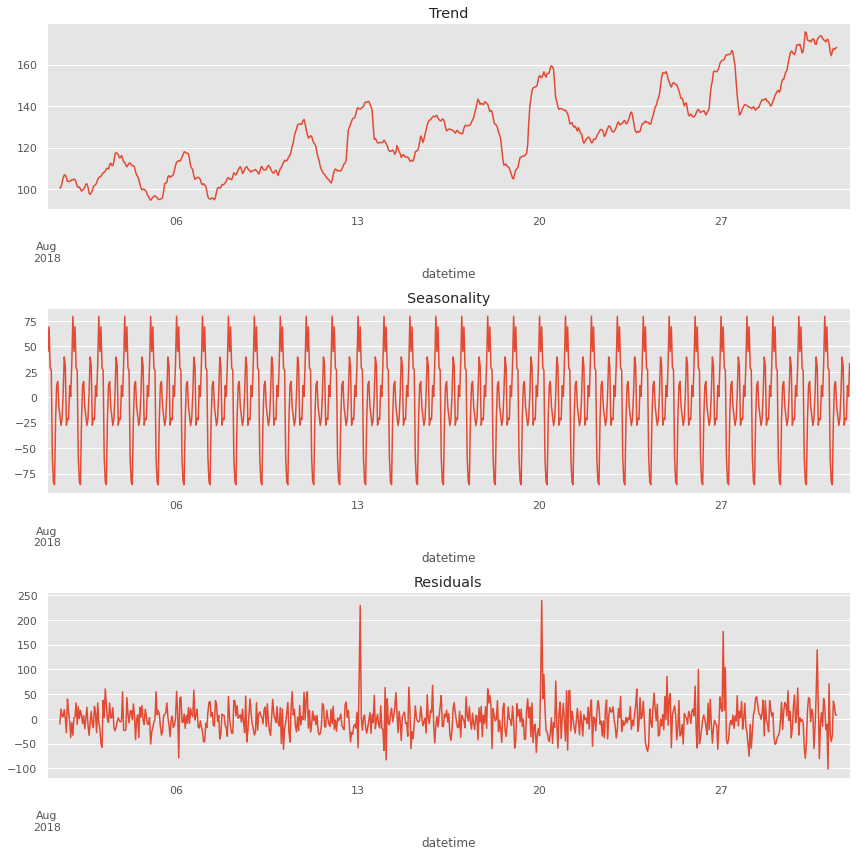

In [9]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(data['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

<b>
   Тренд показывает, что количество заказов равномерно растёт с небольшими просадками.
    
    
   Сезонность показывает, что минимум заказов приходится на ночь, рост утром и днём, пик заказов вечером.</b>

<div class="alert alert-info">
Это характеристики за весь период
</div>

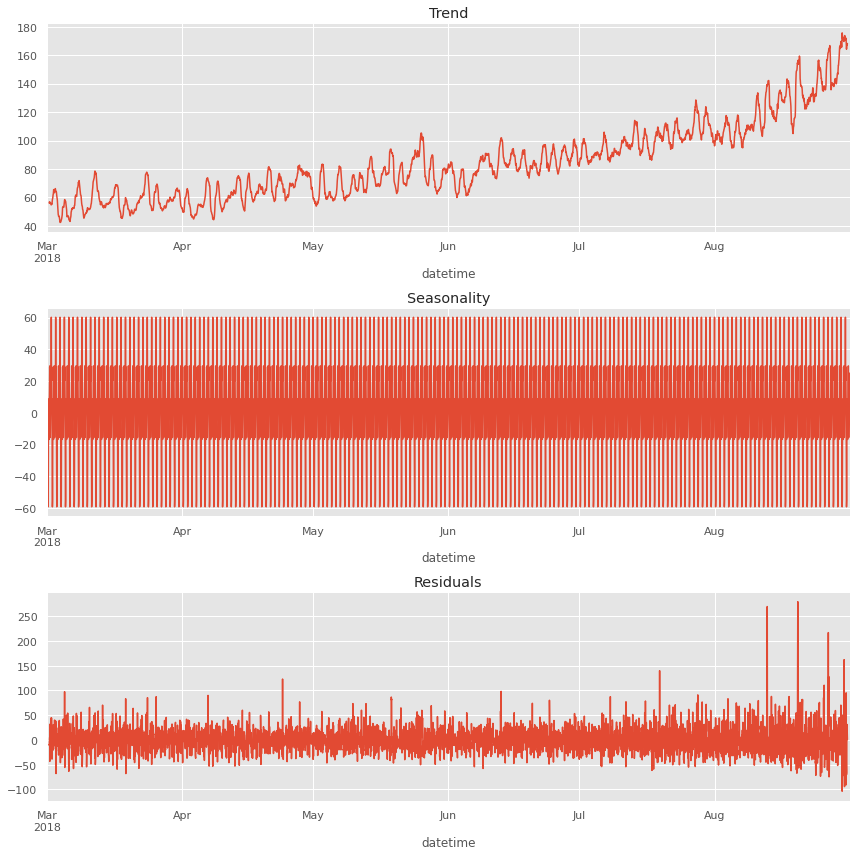

In [10]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())

plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

<b>
   Тренд растёт на протяжении всего периода, скорее всего, растёт не линейно, возможно, экспоненциально, не до конца понятно.
    
    
   Остатков действительно больше в правой части, как вы и говорили).</b>

<div class="alert alert-info">
Анализ сезонности
</div>

<AxesSubplot:xlabel='datetime'>

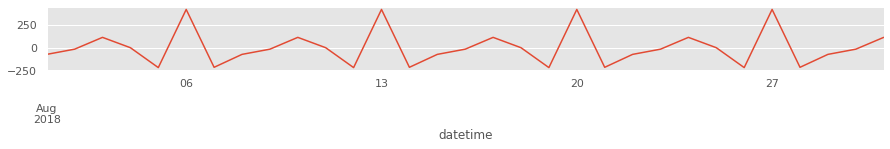

In [11]:
decomposed = seasonal_decompose(data.resample('1D').sum()['2018-08':'2018-08'])

plt.title('Seasonality')
plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca())

<b>Больше всего такси заказывают в понедельник и пятницу, меньше всего во вторник, среду и воскресенье</b>

## Обучение

### Добавление признаков

In [12]:
def make_features(data):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, 24+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(1).mean()
    data.dropna(inplace=True)
    
    return data

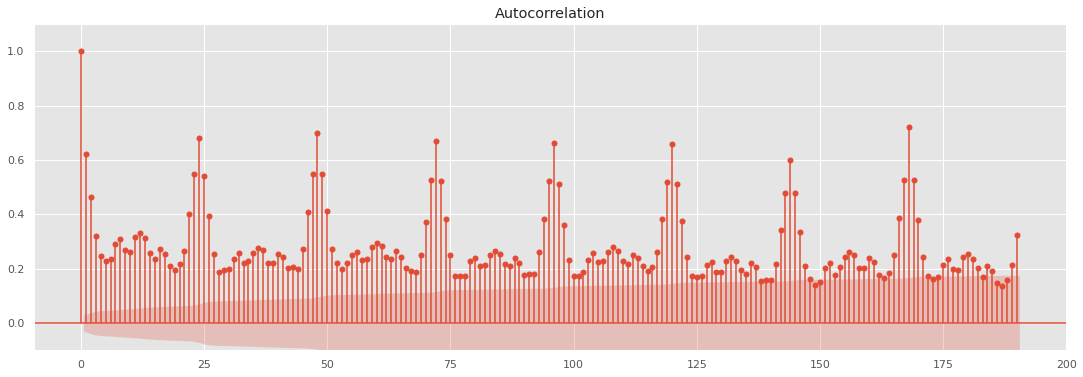

In [13]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


In [14]:
data = make_features(data)

In [15]:
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.0
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,90.0
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,120.0
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,75.0
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.0


<b>Разделим датасет на обучающую и тестовую выборки.</b>

In [16]:
X = data.drop(['num_orders'], axis=1)
y = data['num_orders']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=42)

### Обучение моделей

<b>Будем обучать модели и будем добавлять rmse в список</b>

In [18]:
results = []

#### Линейная регрессия

In [23]:
%%time
#модель линейной регрессии
cv = TimeSeriesSplit(n_splits=3).split(X_train)
model = LinearRegression() 
score_lr = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
rmse = round(np.mean(-score_lr)**0.5, 2)
rmse

CPU times: user 190 ms, sys: 151 ms, total: 341 ms
Wall time: 276 ms


27.75

In [24]:
results.append([model, rmse])

#### LightGBM

In [29]:
%%time
#модель линейной регрессии
cv = TimeSeriesSplit(n_splits=3).split(X_train)
model = lgb.LGBMRegressor()
score_lr = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
rmse = round(np.mean(-score_lr)**0.5, 2)
rmse

CPU times: user 2.68 s, sys: 14 ms, total: 2.69 s
Wall time: 2.64 s


26.76

In [30]:
results.append([model, rmse])

#### DecisionTreeRegressor

In [37]:
%%time
#модель линейной регрессии
cv = TimeSeriesSplit(n_splits=3).split(X_train)
model = DecisionTreeRegressor(random_state=42)
score_lr = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
rmse = round(np.mean(-score_lr)**0.5, 2)
rmse

CPU times: user 163 ms, sys: 2.9 ms, total: 166 ms
Wall time: 181 ms


38.17

In [38]:
results.append([model, rmse])

#### CatBoost

In [43]:
%%time
#модель линейной регрессии
cv = TimeSeriesSplit(n_splits=3).split(X_train)
model = CatBoostRegressor(verbose=False)
score_lr = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
rmse = round(np.mean(-score_lr)**0.5, 2)
rmse

CPU times: user 11.9 s, sys: 296 ms, total: 12.2 s
Wall time: 14.9 s


25.98

In [44]:
results.append([model, rmse])

### Результаты тренировочных выборок

<b>Превратим наш список в датафрейм и отсортируем по убыванию RMSE</b>

In [45]:
results = pd.DataFrame(results, columns=['model', 'training_RMSE'])

In [46]:
results

,model,training_RMSE
0,LinearRegression(),27.75
1,LGBMRegressor(),26.76
2,DecisionTreeRegressor(random_state=42),38.17
3,<catboost.core.CatBoostRegressor object at 0x7...,25.98


<div class="alert alert-info">
Выбираем модель CatBoostRegressor, потому что у неё самая маленькая RMSE. Она самая точная из представленных.
</div>

## Тестирование

In [47]:
model.fit(X_train, y_train)

In [48]:
y_pred = model.predict(X_test)

In [51]:
rmse = mean_squared_error(y_test, y_pred) ** 0.5
rmse

40.08706753297002

<b>RMSE у CatBoost получилась 40.08706753297002, что меньше 48. Разницу между между результатами на кросс-валидации и при тестировании можно объяснить тем, что  «остатков» к концу графика больше, значит в тестовую выборку попало чуть больше данных, которые сложно объяснить и на которых модели будет сложнее предсказывать.</b>

## Вывод

Во время проекта были изучены способы предсказания временных рядов с помощью регрессоров.


Были проанализированы тренд, сезонности и остатки.


Выяснилось, что «остатков» к концу графика больше, значит в тестовую выборку попало чуть больше данных, которые сложно объяснить и на которых модели будет сложнее предсказывать.


Тренд по характеру возрастания похож на экспоненциальную функцию.


Далее, мы обучили несколько моделей: линейную регрессию, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor.



По итогам кросс валидации выиграл CatBoostRegressor, он показал себя лучше всего. (RMSE - 25.98)


По итогам тестирования RMSE у CatBoostRegressor составило 40.08706753297002.